## TASK 2 - GAS TURBINE ANOMALY DETECTION (Jonathan Cauchi)


In [18]:
from pyspark.sql import SparkSession
from tensorflow import keras
from pyspark.ml import Pipeline
from tensorflow.keras import layers
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StandardScaler
from pyspark.ml.param import *
from pyspark.sql.types import *
from handyspark import *
from pyspark.ml.feature import VectorAssembler, StringIndexer
from elephas.spark_model import SparkModel
from statistics import mean, median
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier
from elephas.ml_model import ElephasEstimator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation
from tensorflow.python.keras.utils import np_utils, generic_utils
from sklearn.model_selection import train_test_split
import numpy as np
import findspark
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Installing Java

In [4]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~20.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)


### Installing Hadoop

In [5]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz

In [6]:
!tar xf spark-2.4.7-bin-hadoop2.7.tgz

In [7]:
!pip install -q findspark

In [19]:
import os
os.environ["SPARK_HOME"] = "/home/jonat/Downloads/spark-2.4.7-bin-hadoop2.7" #change path here
import findspark
findspark.init()

### Creating Spark Session

In [20]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

### Define Schema

In [21]:
mySchema = StructType([ StructField("Status", StringType(), True)
                       ,StructField("Temperature_Sensor_1", FloatType(), True)
                       ,StructField("Temperature_Sensor_2", FloatType(), True)
                       ,StructField("Temperature_Sensor_3", FloatType(), True)
                       ,StructField("Flow_Rate_Sensor_1", FloatType(), True)
                       ,StructField("Flow_Rate_Sensor_1_1", FloatType(), True)
                       ,StructField("Flow_Rate_Sensor_1_2", FloatType(), True)
                       ,StructField("Pressure _sensor_1", FloatType(), True)
                       ,StructField("Pressure _sensor_2", FloatType(), True)
                       ,StructField("Pressure _sensor_3", FloatType(), True)
                       ,StructField("Vibration_Sensor_1", FloatType(), True)
                       ,StructField("Vibration_Sensor_2", FloatType(), True)
                       ,StructField("Vibration_Sensor_3", FloatType(), True)])

### Descriptive Stats & Visualizations

In [85]:
def load_dataset():
    data_xls = pd.read_excel('CS551G_DMV_Assessment_2_Dataset.xlsx', dtype=str, index_col=None)
    data_xls.to_csv('csvfile.csv', encoding='utf-8', index=False)
    data = spark.read.csv("csvfile.csv",header=True,schema=mySchema) #creating RDD using schema defined above
    return data

def summary_statistics(df):
    table = {"Mean":{},"Median":{},"Min":{},"Max":{},"Range":{},"Std":{},"25%":{},"50%":{},"75%":{}}
    df = df.toPandas() 
    print(df.describe())
    for i in df:
        if i == "Status":
            continue
        else:
            mean = np.mean(df[i])
            table["Mean"][i] = mean
            median = np.median(df[i])
            table["Median"][i] = median
            minimum = min(df[i])
            table["Min"][i] = minimum
            maximum = max(df[i])
            table["Max"][i] = maximum
            rang = (minimum, maximum)
            table["Range"][i] = rang
            std = np.std(df[i])
            table["Std"][i] = std
            percentile_25 = np.percentile(df[i], 25)
            table["25%"][i] = percentile_25
            percentile_50 = np.percentile(df[i], 50)
            table["50%"][i] = percentile_50
            percentile_75 = np.percentile(df[i], 75)
            table["75%"][i] = percentile_75
    
    #converting nested dicitonaries to dataframe
    df = pd.concat({k: pd.DataFrame.from_dict(v, 'index') for k, v in table.items()}, axis=0)
    df.to_csv('summary_stats.csv')


def visualize_boxplot(hdf,length):
    y=hdf.cols["Vibration_Sensor_1"][:length+1]
    x=hdf.cols["Status"][:length+1]
    fig, ax = plt.subplots(figsize=(12,7))
    ax = sns.boxplot(y=y, x=x)
    plt.title("Box Plot")
    plt.xlabel("Status")
    plt.ylabel("Vibration Sensor 1")

def visualize_scatterplot(df):
    df = df.toPandas()
    fig, ax = plt.subplots(figsize=(12,7))
    ax = sns.scatterplot(x="Vibration_Sensor_1", y="Vibration_Sensor_2", hue="Status", data=df);
    plt.title("Scatter Plot - Vibration Sensor 1 vs Vibration Sensor 2")
    plt.xlabel("Vibration Sensor 1")
    plt.ylabel("Vibration Sensor 2")
    ax.legend(loc='upper right')
    
spark = SparkSession.builder.master("local[*]").appName("Learning_Spark").getOrCreate()    
sc = spark.sparkContext
df = load_dataset()
hdf = df.toHandy()
length = 966

#obtain summary statistics for each column/sensor
summary_statistics(hdf)


INFO: Safety is ON - returning up to 1000 instances.
       Temperature_Sensor_1  Temperature_Sensor_2  Temperature_Sensor_3  \
count            996.000000            996.000000            996.000000   
mean               4.999576              6.379271              9.228111   
std                2.764856              2.312568              2.532173   
min                0.008200              0.040300              2.583966   
25%                2.892120              4.931750              7.511400   
50%                4.881100              6.470500              9.348000   
75%                6.794558              8.104500             11.046800   
max               12.129800             11.928400             15.759900   

       Flow_Rate_Sensor_1  Flow_Rate_Sensor_1_1  Flow_Rate_Sensor_1_2  \
count          996.000000            996.000000            996.000000   
mean             7.355273             14.199129              3.077959   
std              4.354780             11.680045    

### Boxplot & Scatterplot

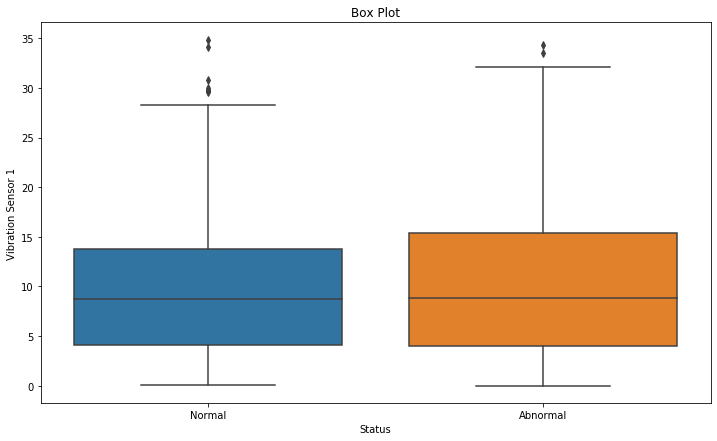

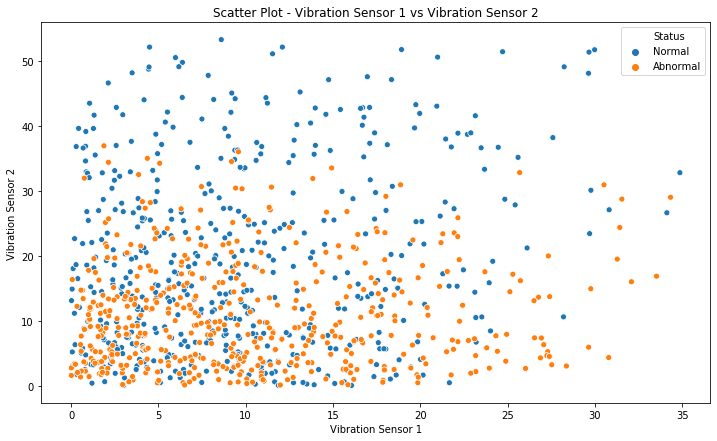

In [76]:
#Plot and Visualize Box Plot
visualize_boxplot(hdf,length)
    
#Plot and Visualize Scatter Plot
visualize_scatterplot(df)

### Data Preprocessing

In [100]:
def preprocess_data(hdf):      
    inputcols = ["Temperature_Sensor_1","Temperature_Sensor_2","Temperature_Sensor_3","Flow_Rate_Sensor_1","Flow_Rate_Sensor_1_1","Flow_Rate_Sensor_1_2", "Pressure _sensor_1", "Pressure _sensor_2", "Pressure _sensor_3", "Vibration_Sensor_1", "Vibration_Sensor_2", "Vibration_Sensor_3"]
    assembler = VectorAssembler(inputCols= inputcols,outputCol = "predictors")
    predictors = assembler.transform(hdf)
    model_data = predictors.select("predictors", "Status")
    input_dim = len(assembler.getInputCols())
    layers = [input_dim, 4, 2, 2]
    
    #converting Status column from categorical to numerical
    indexer = StringIndexer(inputCol="Status", outputCol="Status_Num")
    model_data = indexer.fit(model_data).transform(model_data)
    
    #dropping original column
    model_data = model_data.drop(model_data.Status)
    
    #reduce dimensionality, etc
    scaler = StandardScaler(inputCol="predictors", outputCol="scaled_predictors", withStd=True, withMean=True)
    fitted_scaler = scaler.fit(model_data)
    model_data = fitted_scaler.transform(model_data)
    model_data = model_data.drop(model_data.predictors)
    pandas_data = model_data.toPandas()
    print("How data looks after scaling")
    print(pandas_data.head(10))
    
    #split the dataset
    train_data,test_data = model_data.randomSplit([0.7,0.3])
    return train_data, test_data, layers    

### Random Forest & Multi-Layer Perceptron

In [101]:
def train_randomforest(train_data, test_data):
    rf = RandomForestClassifier(featuresCol = 'scaled_predictors', labelCol = 'Status_Num')
    rfModel = rf.fit(train_data)
    pred = rfModel.transform(test_data)
    print("--------Showing 10 Predictions - Random Forest---------")
    pred.select('rawPrediction','Probability','prediction','Status_Num', 'scaled_predictors').show(10)
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Status_Num')
    print("Area Under ROC: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Status_Num')
    print("Area Under PR: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderPR"})))  
     
    evaluator = MulticlassClassificationEvaluator(labelCol = "Status_Num", predictionCol = "prediction",metricName = "accuracy")
    accuracy = evaluator.evaluate(pred)
    print("Accuracy: {}".format(str(accuracy)))
 
    
def train_MLP(train_data, test_data, layers):
    mlp = MultilayerPerceptronClassifier(labelCol='Status_Num',
                                            featuresCol='scaled_predictors',
                                            maxIter=100,
                                            layers=layers, 
                                            blockSize=128,
                                            seed=1234)
    mlpModel = mlp.fit(train_data)
    pred = mlpModel.transform(test_data)
    print("--------Showing 10 Predictions - Multi-Layer-Perceptron---------")
    pred.select('rawPrediction','Probability','prediction','Status_Num', 'scaled_predictors').show(10)

    evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Status_Num')
    print("Area Under ROC: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Status_Num')
    print("Area Under PR: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderPR"})))
    
    evaluator = MulticlassClassificationEvaluator(labelCol = "Status_Num", predictionCol = "prediction",metricName = "accuracy")
    accuracy = evaluator.evaluate(pred)
    print("Accuracy: {}".format(str(accuracy)))

### Preprocess and split data

In [115]:
train_data, test_data, layers = preprocess_data(hdf)

How data looks after scaling
   Status_Num                                  scaled_predictors
0         0.0  [-0.17909583666950143, -2.4366726567810164, -1...
1         0.0  [-0.20658361557731372, -2.366188272401454, -1....
2         0.0  [-0.1701622179810298, -2.3174978423803063, -1....
3         0.0  [0.06261666911423593, -2.325800284000702, -0.5...
4         0.0  [0.08182205219395626, -2.4936655541967743, -0....
5         0.0  [-0.042018081078966325, -2.5083245873168867, -...
6         0.0  [0.268594872607768, -2.375312318667088, -1.629...
7         0.0  [0.5454266751943924, -2.5233727853062917, -0.8...
8         0.0  [0.22620571424937624, -2.7410960365124852, -0....
9         0.0  [-0.0019435577865587331, -2.5815764522365807, ...


### Train Random Forest Model

In [116]:
train_randomforest(train_data, test_data)

--------Showing 10 Predictions - Random Forest---------
+--------------------+--------------------+----------+----------+--------------------+
|       rawPrediction|         Probability|prediction|Status_Num|   scaled_predictors|
+--------------------+--------------------+----------+----------+--------------------+
|[11.8566616281913...|[0.59283308140956...|       0.0|       0.0|[-1.7771177854017...|
|[5.14787762640804...|[0.25739388132040...|       1.0|       0.0|[-1.7582741233354...|
|[11.7331482051920...|[0.58665741025960...|       0.0|       0.0|[-1.7241674578159...|
|[14.0294835409629...|[0.70147417704814...|       0.0|       0.0|[-1.7002964093780...|
|[6.23558585497247...|[0.31177929274862...|       1.0|       0.0|[-1.5671972400081...|
|[13.4284554118570...|[0.67142277059285...|       0.0|       0.0|[-1.5251335421741...|
|[14.3708067728101...|[0.71854033864050...|       0.0|       0.0|[-1.5016241770232...|
|[5.64889852347385...|[0.28244492617369...|       1.0|       0.0|[-1.36190

### Train Multi-Layer Perceptron Model

In [117]:
train_MLP(train_data, test_data, layers)

--------Showing 10 Predictions - Multi-Layer-Perceptron---------
+--------------------+--------------------+----------+----------+--------------------+
|       rawPrediction|         Probability|prediction|Status_Num|   scaled_predictors|
+--------------------+--------------------+----------+----------+--------------------+
|[1.60643383300656...|[0.98824271459629...|       0.0|       0.0|[-1.7771177854017...|
|[0.39602115506992...|[0.89416234556056...|       0.0|       0.0|[-1.7582741233354...|
|[1.12226593525040...|[0.97099011108567...|       0.0|       0.0|[-1.7241674578159...|
|[-2.0767352027773...|[0.07112771224103...|       1.0|       0.0|[-1.7002964093780...|
|[-0.3499650745169...|[0.67154123572158...|       0.0|       0.0|[-1.5671972400081...|
|[1.56035926532795...|[0.98717980018682...|       0.0|       0.0|[-1.5251335421741...|
|[9.92353889405134...|[0.99999999840418...|       0.0|       0.0|[-1.5016241770232...|
|[0.50591279428357...|[0.91237815586295...|       0.0|       0.0|